In [ ]:
!pip install haystack-ai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.2/440.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 9.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Query Expansion
Query expansion consists of asking an LLM to produce a number of similar queries to a user query. We are then able to use each of these queries in the retrieval process, increasing the number and relevance of retrieved documents.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import rich

HF_API_TOKEN = "<YOUR_HF_API_TOKEN>"
OPENAI_API_TOKEN = "<YOUR_OPENAI_API_TOKEN>"


In [ ]:
import json

from typing import List, Optional
from haystack import Pipeline, component
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.dataclasses import Document

from haystack.utils import Secret

In [ ]:
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.converters.txt import TextFileToDocument
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder, SentenceTransformersTextEmbedder
from haystack.components.writers import DocumentWriter

document_store = InMemoryDocumentStore()


converter = TextFileToDocument()
splitter = DocumentSplitter(split_by='sentence', split_length=1)
embedder = SentenceTransformersDocumentEmbedder("sentence-transformers/all-MiniLM-L6-v2")
writer = DocumentWriter(document_store=document_store)

indexing_pipeline = Pipeline()

indexing_pipeline.add_component("converter", converter)
indexing_pipeline.add_component("splitter", splitter)
indexing_pipeline.add_component("embedder", embedder)
indexing_pipeline.add_component("writer", writer)

indexing_pipeline.connect("converter.documents", "splitter.documents")
indexing_pipeline.connect("splitter.documents", "embedder.documents")
indexing_pipeline.connect("embedder.documents", "writer.documents")

indexing_pipeline.run({"converter": {"sources": ["/content/drive/MyDrive/Colab Notebooks/RAG Code/data/tolkien.txt",
                                                 "/content/drive/MyDrive/Colab Notebooks/RAG Code/data/George_RR_Martin.txt"]}})


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

{'writer': {'documents_written': 92}}

## The Process of Query Expansion

First, let's create a `QueryExpander`. This component is going to be able to create a `number` (defaults to 5) of additional queries, similar to the original user query. It returns `queries` that has the original query + `number` of similar queries.

In [ ]:
@component
class QueryExpander:

    def __init__(self, open_ai_key: str , prompt: Optional[str] = None, model: str = "gpt-4o-mini"):

        self.query_expansion_prompt = prompt
        self.model = model
        self.open_ai_key = open_ai_key
        if prompt == None:
          self.query_expansion_prompt = """
          You are part of an information system that processes users queries.
          You expand a given query into {{ number }} queries that are similar in meaning.

          Structure:
          Follow the structure shown below in examples to generate expanded queries.
          Examples:
          1. Example Query 1: "climate change effects"
          Example Expanded Queries: ["impact of climate change", "consequences of global warming", "effects of environmental changes"]

          2. Example Query 2: ""machine learning algorithms""
          Example Expanded Queries: ["neural networks", "clustering", "supervised learning", "deep learning"]

          Your Task:
          Query: "{{query}}"
          Example Expanded Queries:
          """
        builder = PromptBuilder(self.query_expansion_prompt)
        llm = OpenAIGenerator(model = self.model, api_key = self.open_ai_key)
        self.pipeline = Pipeline()
        self.pipeline.add_component(name="builder", instance=builder)
        self.pipeline.add_component(name="llm", instance=llm)
        self.pipeline.connect("builder", "llm")

    @component.output_types(queries=List[str])
    def run(self, query: str, number: int = 5):
        result = self.pipeline.run({'builder': {'query': query, 'number': number}})
        expanded_query = json.loads(result['llm']['replies'][0]) + [query]
        return {"queries": list(expanded_query)}

## Retrieval Without Query Expansion

In [ ]:
embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
retriever = InMemoryEmbeddingRetriever(document_store=document_store, top_k = 3)

In [ ]:
retrieval_pipeline = Pipeline()
retrieval_pipeline.add_component("query_embedder", embedder)
retrieval_pipeline.add_component("embedding_retriever", retriever)

retrieval_pipeline.connect("query_embedder.embedding", "embedding_retriever.query_embedding")

🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - embedding_retriever: InMemoryEmbeddingRetriever
🛤️ Connections
  - query_embedder.embedding -> embedding_retriever.query_embedding (List[float])

In [ ]:
query = "Tolkien"
retrieval_pipeline.run({"query_embedder":{ "text": query}, "embedding_retriever":{"top_k": 3}})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'embedding_retriever': {'documents': [Document(id=b853324885aa102f9f400a85542e79c1ab616b2b757619fa6ac2ed80cb6d6880, content: 'Tolkien, Robert E. Howard, and H.P. ', meta: {'file_path': 'George_RR_Martin.txt', 'source_id': '110c9ea253b56c8f028fa50060b64f3731095564c9cdd0f3d456235dc630cb40', 'page_number': 1, 'split_id': 5, 'split_idx_start': 822}, score: 0.6696723708513932),
   Document(id=a847283dd2656499e040a902c22d067520bce7a0f6067840e245cda507f94839, content: 'The success of The Hobbit marked Tolkien’s emergence as a prominent author, and his creation of Midd...', meta: {'file_path': 'tolkien.txt', 'source_id': 'c7aa1a939dad99f729d31875c841e2726f081097a061c8b5b88e123cc12f80c3', 'page_number': 1, 'split_id': 25, 'split_idx_start': 4082}, score: 0.6460910230983301),
   Document(id=c5659ae14b331b7045d1c79fb6b49dc1de2fcf571bfa5fdcd4a8ab6753317350, content: 'This dedication to creating a fully realized world set Tolkien apart from other fantasy authors and ...', meta: {'file_path': 'tolk

## Retrieval With Query Expansion

Now let's have a look at what documents we are able to retrieve if we include query expansion in the process. For this step, let's create a `MultiQueryInMemoryEmbeddingRetriever` that is able to use embedding retrieval for each (expanded) query in turn.

This component also handles the same document being retrieved for multiple queries and will not return duplicates.

In [ ]:
@component
class MultiQueryInMemoryEmbeddingRetriever:

    def __init__(self, retriever: InMemoryEmbeddingRetriever,  top_k: int = 3):
        self.retriever = retriever
        self.embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
        self.results = []
        self.ids = set()
        self.top_k = top_k

        self.pipeline = Pipeline()
        self.pipeline.add_component(name="embedder", instance=self.embedder)
        self.pipeline.add_component(name="retriever", instance=self.retriever)
        self.pipeline.connect("embedder", "retriever")


    def add_document(self, document: Document):
        if document.id not in self.ids:
            self.results.append(document)
            self.ids.add(document.id)

    @component.output_types(documents=List[Document])
    def run(self, queries: List[str], top_k: int = None):
        if top_k != None:
          self.top_k = top_k
        for query in queries:
          result = self.pipeline.run({"embedder": {'text':query}, "retriever": {"top_k": self.top_k}})
          for doc in result['retriever']['documents']:
            self.add_document(doc)
        self.results.sort(key=lambda x: x.score, reverse=True)
        return {"documents": self.results}

In [ ]:
query_expander = QueryExpander(open_ai_key=Secret.from_token(OPENAI_API_TOKEN))

retriever = MultiQueryInMemoryEmbeddingRetriever(InMemoryEmbeddingRetriever(document_store=document_store, top_k = 5))

expanded_retrieval_pipeline = Pipeline()
expanded_retrieval_pipeline.add_component("expander", query_expander)
expanded_retrieval_pipeline.add_component("embedding_retriever", retriever)

expanded_retrieval_pipeline.connect("expander.queries", "embedding_retriever.queries")

🚅 Components
  - expander: QueryExpander
  - embedding_retriever: MultiQueryInMemoryEmbeddingRetriever
🛤️ Connections
  - expander.queries -> embedding_retriever.queries (List[str])

In [ ]:
expanded_retrieval_pipeline.run({"expander": {"query": query}}, include_outputs_from=["expander"])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'expander': {'queries': ['J.R.R. Tolkien works',
   "Tolkien's literary contributions",
   'Middle-earth creator',
   "Tolkien's influence on fantasy",
   "Tolkien's novels and stories",
   'Tolkien']},
 'embedding_retriever': {'documents': [Document(id=0bb9ec672b19de5d58c810d61edaca59649aee689897e2e6ec6ec5b4a07a410e, content: 'Despite his achievements, Tolkien faced criticism from some literary circles that dismissed fantasy ...', meta: {'file_path': 'tolkien.txt', 'source_id': 'c7aa1a939dad99f729d31875c841e2726f081097a061c8b5b88e123cc12f80c3', 'page_number': 1, 'split_id': 42, 'split_idx_start': 6828}, score: 0.729707131630033),
   Document(id=1d186c84e8c4b5a65ee8b9c68b9941780ed2ee66ec6762c13e8f73ab3742cd52, content: 'In addition to his novels, Tolkien wrote essays and letters in which he discussed his creative proce...', meta: {'file_path': 'tolkien.txt', 'source_id': 'c7aa1a939dad99f729d31875c841e2726f081097a061c8b5b88e123cc12f80c3', 'page_number': 1, 'split_id': 34, 'split_idx_st

## Query Expansion for RAG

### RAG without Query Expansion

In [ ]:
template = """
You are part of an information system that summarises related documents.
You answer a query using the textual content from the documents retrieved for the
following query.

You should reference the documents you used to support your answer.
###
Original Query: "{{query}}"
Retrieved Documents: {{documents}}
Summary Answer:
"""
embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
retriever = InMemoryEmbeddingRetriever(document_store=document_store, top_k = 3)
prompt_builder = PromptBuilder(template = template)
llm = OpenAIGenerator(api_key=Secret.from_token(OPENAI_API_TOKEN))

rag_pipeline = Pipeline()
rag_pipeline.add_component("embedder", embedder)
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt", prompt_builder)
rag_pipeline.add_component("llm", llm)

rag_pipeline.connect("embedder.embedding", "retriever.query_embedding")
rag_pipeline.connect("retriever.documents", "prompt.documents")
rag_pipeline.connect("prompt", "llm")

🚅 Components
  - embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> llm.prompt (str)

In [ ]:
query = "Tolkien"
res = rag_pipeline.run({"embedder": {"text": query}, "retriever": {"top_k": 3}}, include_outputs_from=["retriever"])
rich.print(res["llm"]["replies"])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[
    'The documents retrieved highlight the significance of J.R.R. Tolkien\'s contributions to the fantasy genre, 
particularly in relation to other notable authors. Tolkien\'s success began with "The Hobbit," which established 
him as a prominent author and laid the foundation for his more expansive world-building in works like "The Lord of 
the Rings." This dedication to crafting a fully realized universe distinguishes him from other fantasy writers of 
his time, such as Robert E. Howard and H.P. Lovecraft (Document id: 
b853324885aa102f9f400a85542e79c1ab616b2b757619fa6ac2ed80cb6d6880) (Document id: 
a847283dd2656499e040a902c22d067520bce7a0f6067840e245cda507f94839) (Document id: 
c5659ae14b331b7045d1c79fb6b49dc1de2fcf571bfa5fdcd4a8ab6753317350).'
]

### RAG with Query Expansion

In [ ]:
template = """
You are part of an information system that summarises related documents.
You answer a query using the textual content from the documents retrieved for the
following query.

You should reference the documents you used to support your answer.
###
Original Query: "{{query}}"
Retrieved Documents: {{documents}}
Summary Answer:
"""
query_expander = QueryExpander(open_ai_key=Secret.from_token(OPENAI_API_TOKEN))
query_retriever = MultiQueryInMemoryEmbeddingRetriever(InMemoryEmbeddingRetriever(document_store=document_store, top_k = 5))
prompt_builder = PromptBuilder(template = template)
llm = OpenAIGenerator(api_key=Secret.from_token(OPENAI_API_TOKEN))

query_expanded_rag_pipeline = Pipeline()
query_expanded_rag_pipeline.add_component("expander", query_expander)
query_expanded_rag_pipeline.add_component("retriever", query_retriever)
query_expanded_rag_pipeline.add_component("prompt", prompt_builder)
query_expanded_rag_pipeline.add_component("llm", llm)

query_expanded_rag_pipeline.connect("expander.queries", "retriever.queries")
query_expanded_rag_pipeline.connect("retriever.documents", "prompt.documents")
query_expanded_rag_pipeline.connect("prompt", "llm")

🚅 Components
  - expander: QueryExpander
  - retriever: MultiQueryInMemoryEmbeddingRetriever
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - expander.queries -> retriever.queries (List[str])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> llm.prompt (str)

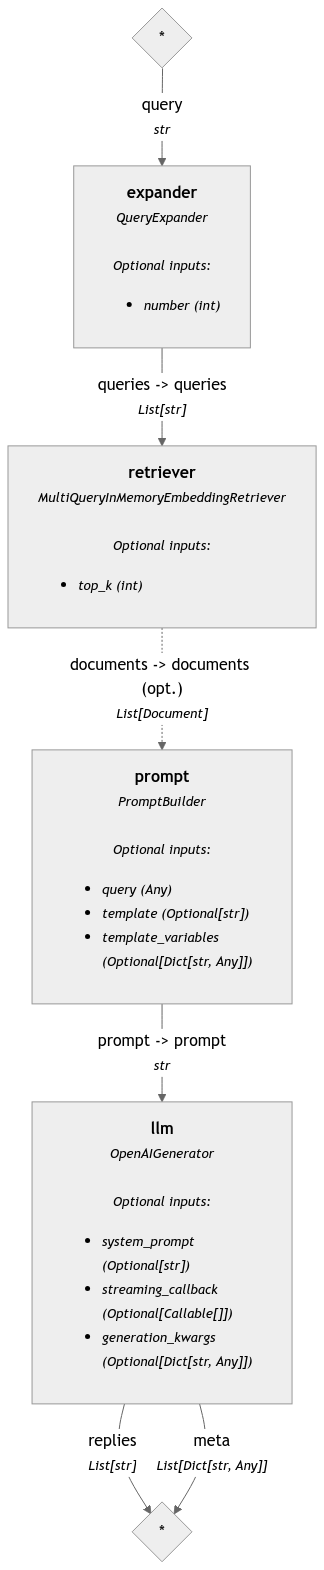

In [ ]:
query_expanded_rag_pipeline.show()

In [ ]:
query = "Tolkien"
res = query_expanded_rag_pipeline.run({"expander": {"query": query}, "retriever": {"top_k": 3}}, include_outputs_from={"retriever", "expander"})

rich.print(res['llm']['replies'])
print("Expander: ", res['expander'])
print("Retriver: ", res['retriever'])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[
    'J.R.R. Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is celebrated as a master of fantasy 
literature, primarily due to his renowned works, "The Hobbit" and "The Lord of the Rings." His dedication to 
creating a fully realized world of Middle-earth, rich with history, languages, and cultures, distinguished him from
other fantasy authors. Despite facing criticism from literary circles that dismissed fantasy as trivial, Tolkien\'s
innovative storytelling and vivid imagination resonated with readers globally, solidifying his legacy in the 
literary world. He also wrote essays and letters detailing his creative processes, further enriching his 
contribution to literature (Documents: c5659ae14b331b7045d1c79fb6b49dc1de2fcf571bfa5fdcd4a8ab6753317350, 
efa43e4ed4c2b1cebbd4391e2d869c7c78374371dedb6bcb9dad5c5077a26e49, 
0bb9ec672b19de5d58c810d61edaca59649aee689897e2e6ec6ec5b4a07a410e, 
d76b99b03b57c461a1326948928128c5dc2a98cde0155e3f101c1285b7c3de8a, 
9c8dc10e30d064f94082e19aa9ff91bdf0e249488d650f19bd4b8d62ad7fe60f).'
]

Expander:  {'queries': ['J.R.R. Tolkien', "Tolkien's works", "Tolkien's Middle-earth", 'The Hobbit and The Lord of the Rings', "Tolkien's influence on fantasy literature", 'Tolkien']}
Retriver:  {'documents': [Document(id=c5659ae14b331b7045d1c79fb6b49dc1de2fcf571bfa5fdcd4a8ab6753317350, content: 'This dedication to creating a fully realized world set Tolkien apart from other fantasy authors and ...', meta: {'file_path': 'tolkien.txt', 'source_id': 'c7aa1a939dad99f729d31875c841e2726f081097a061c8b5b88e123cc12f80c3', 'page_number': 1, 'split_id': 33, 'split_idx_start': 5460}, score: 0.7692606193681126), Document(id=efa43e4ed4c2b1cebbd4391e2d869c7c78374371dedb6bcb9dad5c5077a26e49, content: 'The cinematic adaptations of The Lord of the Rings and The Hobbit, directed by Peter Jackson, introd...', meta: {'file_path': 'tolkien.txt', 'source_id': 'c7aa1a939dad99f729d31875c841e2726f081097a061c8b5b88e123cc12f80c3', 'page_number': 1, 'split_id': 46, 'split_idx_start': 7391}, score: 0.7533922388672